In [10]:
import pandas as pd
import numpy as np
import os
import sys
import re
from collections import OrderedDict
from tqdm import tqdm

class sentistrength:
    def __init__(self, config=dict()):
        lexicon_dir = "LEXICON"
        self.negasi = [line.replace('\n','') for line in open(os.path.join(lexicon_dir, "negatingword.txt")).read().splitlines()]
        self.tanya = [line.replace('\n','') for line in open(os.path.join(lexicon_dir, "questionword.txt")).read().splitlines()]
        self.sentiwords_txt = [line.replace('\n','').split(":") for line in open(os.path.join(lexicon_dir, "sentiwords_id.txt")).read().splitlines()]
        self.sentiwords_dict = OrderedDict()
        for term in self.sentiwords_txt:
            self.sentiwords_dict[term[0]] = int(term[1])
        self.emoticon_txt = [line.replace('\n','').split(" | ") for line in open(os.path.join(lexicon_dir, "emoticon_id.txt")).read().splitlines()]
        self.emoticon_dict = OrderedDict()
        for term in self.emoticon_txt:
            self.emoticon_dict[term[0]] = int(term[1])
        self.idioms_txt = [line.replace('\n','').split(":") for line in open(os.path.join(lexicon_dir, "idioms_id.txt")).read().splitlines()]
        self.idioms_dict = OrderedDict()
        for term in self.idioms_txt:
            self.idioms_dict[term[0]] = int(term[1])
        self.boosterwords_txt = [line.replace('\n','').split(":") for line in open(os.path.join(lexicon_dir, "boosterwords_id.txt")).read().splitlines()]
        self.boosterwords_dict = OrderedDict()
        for term in self.boosterwords_txt:
            self.boosterwords_dict[term[0]] = int(term[1])
        self.negation_conf = config["negation"]
        self.booster_conf = config["booster"]
        self.ungkapan_conf = config["ungkapan"]
        self.consecutive_conf = config["consecutive"]
        self.repeated_conf = config["repeated"]
        self.emoticon_conf = config["emoticon"]
        self.question_conf = config["question"]
        self.exclamation_conf = config["exclamation"]
        self.punctuation_conf = config["punctuation"]
        self.mean_conf = False

    def senti(self,term):
        try:
            return self.sentiwords_dict[term]
        except:
            return 0

    def emosikon(self,term):
        try:
            return self.emoticon_dict[term]
        except:
            return 0

    def ungkapan(self,term):
        try:
            return self.idioms_dict[term]
        except:
            return 0

    def booster(self, term):
        try:
            return self.boosterwords_dict[term]
        except:
            return 0

    def cek_negationword(self, prev_term, prev_term2):
        if prev_term in self.negasi or prev_term2+" "+prev_term in self.negasi:
            self.score = -abs(self.score) if self.score>0 else abs(self.score)

    def cek_boosterword(self,term):
        booster_score = self.booster(term)
        if booster_score !=0 and self.score>0: self.score += booster_score
        if booster_score !=0 and self.score<0: self.score -= booster_score

    def cek_consecutive_term(self, prev_term):
        if self.prev_score>0 and self.score >=3: self.score+=1 
        if self.prev_score<0 and self.score <=-3: self.score-=1 

    def cek_ungkapan(self, bigram,trigram, i):
        bigram = ' '.join(bigram)
        trigram = ' '.join(trigram)
        ungkapan_score = self.ungkapan(bigram)
        if ungkapan_score==0:
            ungkapan_score = self.ungkapan(trigram)
        if ungkapan_score!=0:
            self.score = ungkapan_score
            self.prev_score = 0
            self.pre_max_pos[i-1] = 1
            self.pre_max_neg[i-1] = -1
            self.max_pos = self.pre_max_pos[i-2]
            self.max_neg = self.pre_max_neg[i-2]
            self.sentence_score[i-1] = re.sub(r'\[\d\]','',self.sentence_score[i-1])

    def cek_repeated_punctuation(self, next_term):
        if re.search(r'!{2,}',next_term) and self.score >=3: self.score+=1
        if re.search(r'!{2,}',next_term) and self.score <=-3: self.score-=1

    def remove_extra_repeated_char(self, term):
        return re.sub(r'([A-Za-z])\1{2,}',r'\1',term)

    def plural_to_singular(self, term):
        return re.sub(r'([A-Za-z]+)\-\1', r'\1',term)

    def classify(self):
        result = "neutral"
        try:
            if self.mean_conf:
                mean_p = np.mean(self.mean_pos)
                mean_n = np.mean(self.mean_neg)
                if mean_p > mean_n:
                    result = "positive"
                elif mean_p < mean_n and not self.is_tanya:
                    result = "negative"
                elif mean_p < mean_n and self.is_tanya:
                    result = "neutral"
            else:
                if abs(self.sentences_max_pos) > abs(self.sentences_max_neg):
                    result = "positive"
                elif abs(self.sentences_max_pos) < abs(self.sentences_max_neg):
                    result = "negative"
                elif abs(self.sentences_max_pos) == abs(self.sentences_max_neg):
                    result = "neutral"
        except:
            print("error ",self.sentences_max_pos, self.sentences_max_neg)
        return result

    def cek_neutral_term(self,terms,i):
        if terms[i-1] in self.neutral_term or terms[i+1] in self.neutral_term: self.score=1

    def main(self,sentence):
        self.neutral_term = ['jika','kalau']
        sentences = sentence.split('.')
        self.sentences_max_neg = -1
        self.sentences_max_pos = 1
        self.sentences_score = []
        self.sentences_text = []

        for sentence in sentences:
            self.max_neg = -1
            self.max_pos = 1
            self.mean_neg = [1]
            self.mean_pos = [1]
            self.sentence_score=[]
            terms = sentence.split()
            terms_length = len(terms)
            self.is_tanya = False
            self.sentence_text = ''

            if self.exclamation_conf and re.search('!',sentence): self.max_pos = 2
            self.prev_score = 0
            self.pre_max_pos = []
            self.pre_max_neg = []

            for i,term in enumerate(terms):
                is_extra_char = False
                plural = ''
                self.score = 0

                if re.search(r'([A-Za-z])\1{3,}',term):
                    is_extra_char = True
                term = self.remove_extra_repeated_char(term)
                if re.search(r'([A-Za-z]+)\-\1',term):
                    plural = term
                    term = self.plural_to_singular(term)

                self.score = self.senti(term)

                if self.negation_conf and self.score !=0 and i>0:
                    self.cek_negationword(terms[i-1],terms[i-2])

                if self.booster_conf and self.score !=0 and i>0 and i<=(terms_length-1):
                    self.cek_boosterword(terms[i-1])
                if self.booster_conf and self.score !=0 and i>=0 and i<(terms_length-1):
                    self.cek_boosterword(terms[i+1])

                if self.ungkapan_conf and i>0 and i<=(terms_length-1):
                    self.cek_ungkapan([terms[i-1],term],[terms[i-2],terms[i-1],term],i)

                if self.consecutive_conf and i>0 and i<=(terms_length-1) and self.score !=0:
                    self.cek_consecutive_term(terms[i-1])

                if self.repeated_conf and is_extra_char==True and self.score>0: self.score+=1
                if self.repeated_conf and is_extra_char==True and self.score<0: self.score-=1
                if self.repeated_conf and is_extra_char==True and self.score==0: self.score=2

                if self.punctuation_conf and i>=0 and i<(terms_length-1):
                    self.cek_repeated_punctuation(terms[i+1])

                if self.question_conf and (term in self.tanya or re.search(r'\?',term)):
                    self.is_tanya = True

                if self.score!=0 and i>1 and i<(terms_length-2):
                    self.cek_neutral_term(terms,i)

                if self.emoticon_conf and self.score==0:
                    self.score = self.emosikon(term)

                self.prev_score = self.score
                if self.mean_conf and self.score>0: self.mean_pos.append(self.score)    
                if self.mean_conf and self.score<0: self.mean_neg.append(abs(self.score))

                self.max_pos= self.score if self.score > self.max_pos else self.max_pos
                self.max_neg= self.score if self.score < self.max_neg else self.max_neg

                self.pre_max_pos.append(self.max_pos)
                self.pre_max_neg.append(self.max_neg)

                if plural !='': term = plural
                self.sentence_text += ' {}'.format(term)
                if self.score != 0:term = "{} [{}]".format(term, self.score)
                self.sentence_score.append(term)

            self.sentences_text.append(self.sentence_text)
            self.sentences_score.append(" ".join(self.sentence_score))
            if self.is_tanya: 
                self.max_neg = -1
            self.sentences_max_pos = self.max_pos if self.max_pos > self.sentences_max_pos else self.sentences_max_pos
            self.sentences_max_neg = self.max_neg if self.max_neg < self.sentences_max_neg else self.sentences_max_neg

        sentence_result = self.classify()
        return self.sentences_max_pos + self.sentences_max_neg

class LexiconAnalyzer:
    def __init__(self):
        try:
            self.inset = pd.read_csv(os.path.join("LEXICON", 'inset.csv'))
            
            config = {
                "negation": True,
                "booster": True,
                "ungkapan": True,
                "consecutive": True,
                "repeated": True,
                "emoticon": True,
                "question": True,
                "exclamation": True,
                "punctuation": True
            }
            self.sentistrength = sentistrength(config)
        except Exception as e:
            print(f"Error initializing LexiconAnalyzer: {e}")
            raise
        
    def get_inset_score(self, tokens):
        try:
            score = 0
            if isinstance(tokens, list):
                for token in tokens:
                    # Match using 'word' column
                    match = self.inset[self.inset['word'] == token]
                    if not match.empty:
                        # Get score from 'weight' column
                        score += match.iloc[0]['weight']
            return float(score)
        except Exception as e:
            print(f"Error in InSet scoring: {e}")
            return 0.0
    
    def get_sentistrength_score(self, text):
        try:
            if isinstance(text, list):
                text = ' '.join(text)
            return float(self.sentistrength.main(text))
        except Exception as e:
            print(f"Error in Sentistrength scoring: {e}")
            return 0.0
    
    def analyze_sentiment(self, text):
        try:
            inset_score = self.get_inset_score(text)
            senti_score = self.get_sentistrength_score(text)
            combined_score = inset_score + senti_score
            return inset_score, senti_score, combined_score
        except Exception as e:
            print(f"Error in sentiment analysis: {e}")
            return 0.0, 0.0, 0.0

def main():
    try:
        print("Membaca file DATA_DEBAT_TOTAL.csv...")
        df = pd.read_csv('Proses/DATA_DEBAT_TOTAL.csv')
        
        print("Inisialisasi analyzer...")
        analyzer = LexiconAnalyzer()
        
        print("Menghitung skor sentimen...")
        tqdm.pandas()
        scores = df['Stemming'].progress_apply(eval).progress_apply(analyzer.analyze_sentiment)
        
        print("Membuat dataframe hasil...")
        result_df = pd.DataFrame({
            'conversation_id_str': df['conversation_id_str'], 
            'full_text': df['full_text'],
            'lang': df['lang'],
            'location': df['location'],
            'Stemming': df['Stemming'],
            'Paslon': df['Paslon'],
            'Debat': df['Debat'],
            'InSet_Score': scores.apply(lambda x: x[0]),
            'Sentistrength_Score': scores.apply(lambda x: x[1]),
            'Combined_Score': scores.apply(lambda x: x[2])
        })
        
        print("Menyimpan hasil analisis...")
        result_df.to_csv('Proses/Hasil_Lexicon_TOTAL.csv', index=False)
        print('Hasil analisis lexicon tersimpan di Hasil_Lexicon_TOTAL.csv')
        
    except Exception as e:
        print(f"Terjadi kesalahan dalam proses utama: {e}")

if __name__ == '__main__':
    main()

Membaca file DATA_DEBAT_TOTAL.csv...
Inisialisasi analyzer...
Menghitung skor sentimen...


100%|██████████| 6581/6581 [02:14<00:00, 49.03it/s]


Membuat dataframe hasil...
Menyimpan hasil analisis...
Hasil analisis lexicon tersimpan di Hasil_Lexicon_TOTAL.csv


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

def convert_to_sentiment_label(score):
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    return 'neutral'

# Load data
df = pd.read_csv('Proses/Hasil_Lexicon_TOTAL.csv')

# Prepare features (X) and target (y)
X = df[['InSet_Score', 'Sentistrength_Score']]
y = df['Combined_Score'].apply(convert_to_sentiment_label)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train SVM on full dataset
svm = SVC(kernel='rbf')
svm.fit(X_scaled, y)

# Function to predict sentiment for new opinions
def predict_sentiment(text, inset_score, sentistrength_score):
    # Create feature vector
    features = np.array([[inset_score, sentistrength_score]])
    
    # Scale features using the same scaler
    features_scaled = scaler.transform(features)
    
    # Predict
    prediction = svm.predict(features_scaled)[0]
    
    return {
        'Text': text,
        'InSet_Score': inset_score,
        'Sentistrength_Score': sentistrength_score,
        'Predicted_Sentiment': prediction
    }

# Test cases
test_opinions = [
    {
        'text': "Layanan sangat bagus, pegawai ramah dan profesional",
        'inset_score': 2,
        'sentistrength_score': 3
    },
    {
        'text': "Produk biasa saja, tidak ada yang istimewa",
        'inset_score': 0,
        'sentistrength_score': 0
    },
    {
        'text': "Pelayanan buruk, harga mahal dan kualitas mengecewakan",
        'inset_score': -2,
        'sentistrength_score': -3
    }
]

# Predict sentiment for test cases
print("\nTest Results:")
print("-------------")
for opinion in test_opinions:
    result = predict_sentiment(
        opinion['text'],
        opinion['inset_score'],
        opinion['sentistrength_score']
    )
    print("\nText:", result['Text'])
    print("InSet Score:", result['InSet_Score'])
    print("Sentistrength Score:", result['Sentistrength_Score'])
    print("Predicted Sentiment:", result['Predicted_Sentiment'])


Test Results:
-------------

Text: Layanan sangat bagus, pegawai ramah dan profesional
InSet Score: 2
Sentistrength Score: 3
Predicted Sentiment: positive

Text: Produk biasa saja, tidak ada yang istimewa
InSet Score: 0
Sentistrength Score: 0
Predicted Sentiment: neutral

Text: Pelayanan buruk, harga mahal dan kualitas mengecewakan
InSet Score: -2
Sentistrength Score: -3
Predicted Sentiment: negative


batas


Classification Report:
              precision    recall  f1-score   support

    negative       0.97      1.00      0.98       329
     neutral       1.00      0.87      0.93        85
    positive       1.00      1.00      1.00       903

    accuracy                           0.99      1317
   macro avg       0.99      0.96      0.97      1317
weighted avg       0.99      0.99      0.99      1317


F1-Score for each class:
negative: 0.984
neutral: 0.931
positive: 1.000

Overall F1-Score (macro avg):
0.971

Results saved to SVM_Results.csv


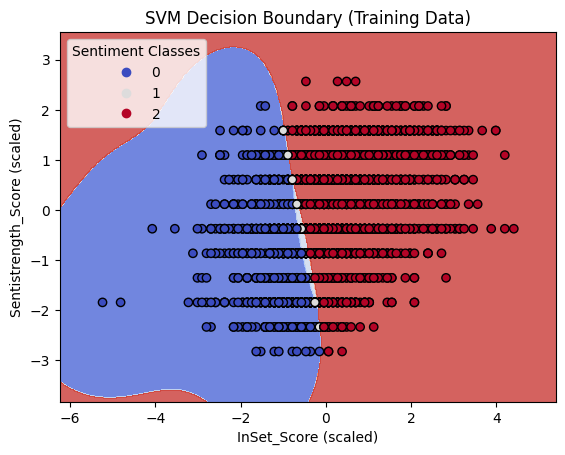

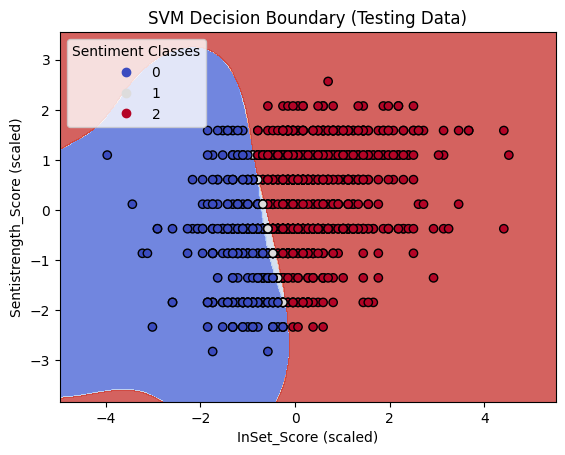

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Fungsi untuk mengonversi skor menjadi label sentimen
def convert_to_sentiment_label(score):
    if score > 0:
        return 'positive'
    elif score < 0:
        return 'negative'
    return 'neutral'

# Load data
df = pd.read_csv('Proses/Hasil_Lexicon_TOTAL.csv')

# Siapkan fitur (X) dan target (y)
X = df[['InSet_Score', 'Sentistrength_Score']]
y = df['Combined_Score'].apply(convert_to_sentiment_label)

# Normalisasi fitur
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Bagi data menjadi training set (80%) dan testing set (20%)
indices = np.arange(len(X))
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_scaled, y, indices, test_size=0.2, random_state=42
)

# Encode label string ke numerik
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Latih model SVM
svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train, y_train_encoded)

# Prediksi sentimen pada data testing
y_pred = svm.predict(X_test)

# Evaluasi model
print("\nClassification Report:")
print(classification_report(y_test, label_encoder.inverse_transform(y_pred)))

print("\nF1-Score for each class:")
classes = np.unique(y)
f1_scores = f1_score(y_test_encoded, y_pred, average=None)
for cls, f1 in zip(classes, f1_scores):
    print(f"{cls}: {f1:.3f}")

print("\nOverall F1-Score (macro avg):")
print(f"{f1_score(y_test_encoded, y_pred, average='macro'):.3f}")

# Simpan hasil prediksi
df_results = pd.DataFrame({
    'Text': df['full_text'].iloc[idx_test].values,
    'Actual': y_test,
    'Predicted': label_encoder.inverse_transform(y_pred)
})
df_results.to_csv('Proses/SVM_Results.csv', index=False)
print("\nResults saved to SVM_Results.csv")

# Fungsi untuk visualisasi hyperplane
def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap='coolwarm')
    plt.xlabel('InSet_Score (scaled)')
    plt.ylabel('Sentistrength_Score (scaled)')
    plt.title(title)
    plt.legend(*scatter.legend_elements(), title="Sentiment Classes")
    plt.show()

# Visualisasi hyperplane untuk data training
plot_decision_boundary(svm, X_train, y_train_encoded, "SVM Decision Boundary (Training Data)")

# Visualisasi hyperplane untuk data testing
plot_decision_boundary(svm, X_test, y_test_encoded, "SVM Decision Boundary (Testing Data)")

batas

TOTAL PENYEBARAN DATA TANPA DIPISAH PER PASLON

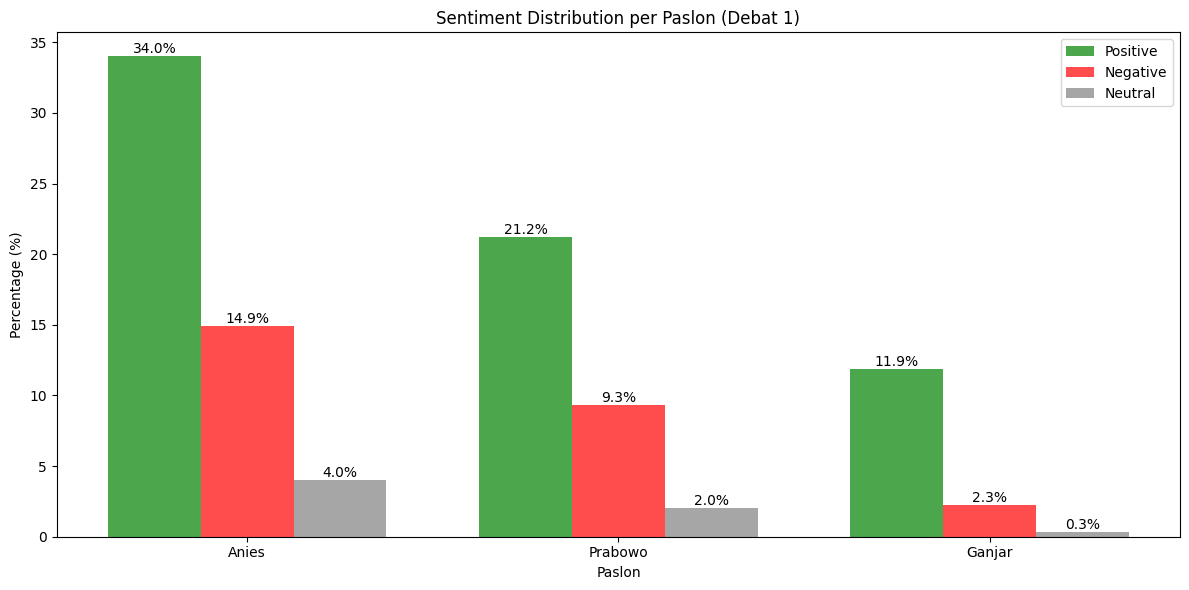

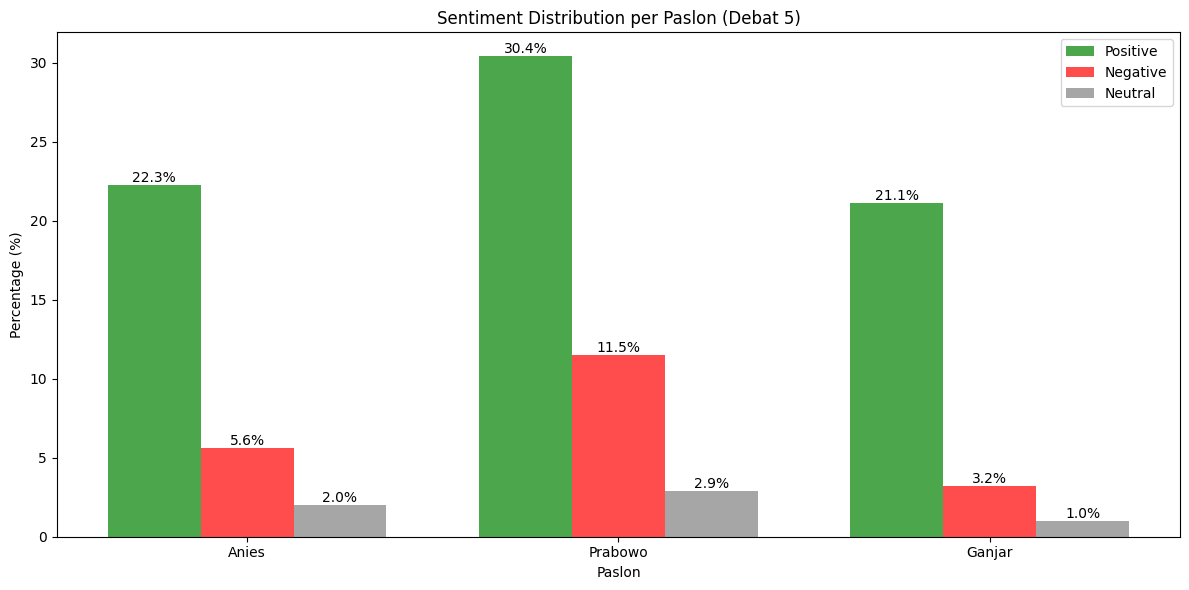


Sentiment Percentages per Paslon (Debat 1):
           Anies  Prabowo  Ganjar
Sentiment                        
Positive   34.00    21.19   11.89
Negative   14.90     9.35    2.28
Neutral     4.04     2.03    0.33

Sentiment Percentages per Paslon (Debat 5):
           Anies  Prabowo  Ganjar
Sentiment                        
Positive   22.28    30.42   21.11
Negative    5.64    11.49    3.22
Neutral     2.01     2.87    0.97


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
df = pd.read_csv('Proses/Hasil_Lexicon_TOTAL.csv')

# Convert Combined_Score to sentiment labels
df['Sentiment'] = df['Combined_Score'].apply(
    lambda x: 'Positive' if x > 0 else 'Negative' if x < 0 else 'Neutral'
)

# Function to calculate sentiment percentages for each Paslon based on total data
def calculate_sentiment_percentages(data, total_length):
    paslon_sentiment = pd.DataFrame()
    for paslon in data['Paslon'].unique():
        paslon_data = data[data['Paslon'] == paslon]
        sentiment_counts = paslon_data['Sentiment'].value_counts()
        percentages = (sentiment_counts / total_length) * 100
        paslon_sentiment[paslon] = percentages
    return paslon_sentiment

# Separate data based on Debat category
if 'Debat' in df.columns:
    debat1_data = df[df['Debat'] == 'Debat 1']
    debat5_data = df[df['Debat'] == 'Debat 5']

    total_length_debat1 = len(debat1_data)
    total_length_debat5 = len(debat5_data)

    # Calculate sentiment percentages for each Debat based on total data
    debat1_sentiment = calculate_sentiment_percentages(debat1_data, total_length_debat1)
    debat5_sentiment = calculate_sentiment_percentages(debat5_data, total_length_debat5)

    # Ensure all required sentiment labels are present in the DataFrame
    required_labels = ['Positive', 'Negative', 'Neutral']
    for label in required_labels:
        if label not in debat1_sentiment.index:
            debat1_sentiment.loc[label] = 0
        if label not in debat5_sentiment.index:
            debat5_sentiment.loc[label] = 0

    # Plotting for Debat 1
    plt.figure(figsize=(12, 6))
    bar_width = 0.25
    r1 = np.arange(len(debat1_sentiment.columns))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    plt.bar(r1, debat1_sentiment.loc['Positive'], width=bar_width, label='Positive', color='green', alpha=0.7)
    plt.bar(r2, debat1_sentiment.loc['Negative'], width=bar_width, label='Negative', color='red', alpha=0.7)
    plt.bar(r3, debat1_sentiment.loc['Neutral'], width=bar_width, label='Neutral', color='gray', alpha=0.7)

    for i, sentiment in enumerate(['Positive', 'Negative', 'Neutral']):
        for j in range(len(debat1_sentiment.columns)):
            value = debat1_sentiment.loc[sentiment, debat1_sentiment.columns[j]]
            x = j + i * bar_width
            plt.text(x, value, f'{value:.1f}%', ha='center', va='bottom')

    plt.xlabel('Paslon')
    plt.ylabel('Percentage (%)')
    plt.title('Sentiment Distribution per Paslon (Debat 1)')
    plt.xticks([r + bar_width for r in range(len(debat1_sentiment.columns))], debat1_sentiment.columns)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plotting for Debat 5
    plt.figure(figsize=(12, 6))
    r1 = np.arange(len(debat5_sentiment.columns))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    plt.bar(r1, debat5_sentiment.loc['Positive'], width=bar_width, label='Positive', color='green', alpha=0.7)
    plt.bar(r2, debat5_sentiment.loc['Negative'], width=bar_width, label='Negative', color='red', alpha=0.7)
    plt.bar(r3, debat5_sentiment.loc['Neutral'], width=bar_width, label='Neutral', color='gray', alpha=0.7)

    for i, sentiment in enumerate(['Positive', 'Negative', 'Neutral']):
        for j in range(len(debat5_sentiment.columns)):
            value = debat5_sentiment.loc[sentiment, debat5_sentiment.columns[j]]
            x = j + i * bar_width
            plt.text(x, value, f'{value:.1f}%', ha='center', va='bottom')

    plt.xlabel('Paslon')
    plt.ylabel('Percentage (%)')
    plt.title('Sentiment Distribution per Paslon (Debat 5)')
    plt.xticks([r + bar_width for r in range(len(debat5_sentiment.columns))], debat5_sentiment.columns)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Print numerical results
    print("\nSentiment Percentages per Paslon (Debat 1):")
    print(debat1_sentiment.round(2))

    print("\nSentiment Percentages per Paslon (Debat 5):")
    print(debat5_sentiment.round(2))
else:
    print("Column 'Debat' not found in the DataFrame.")

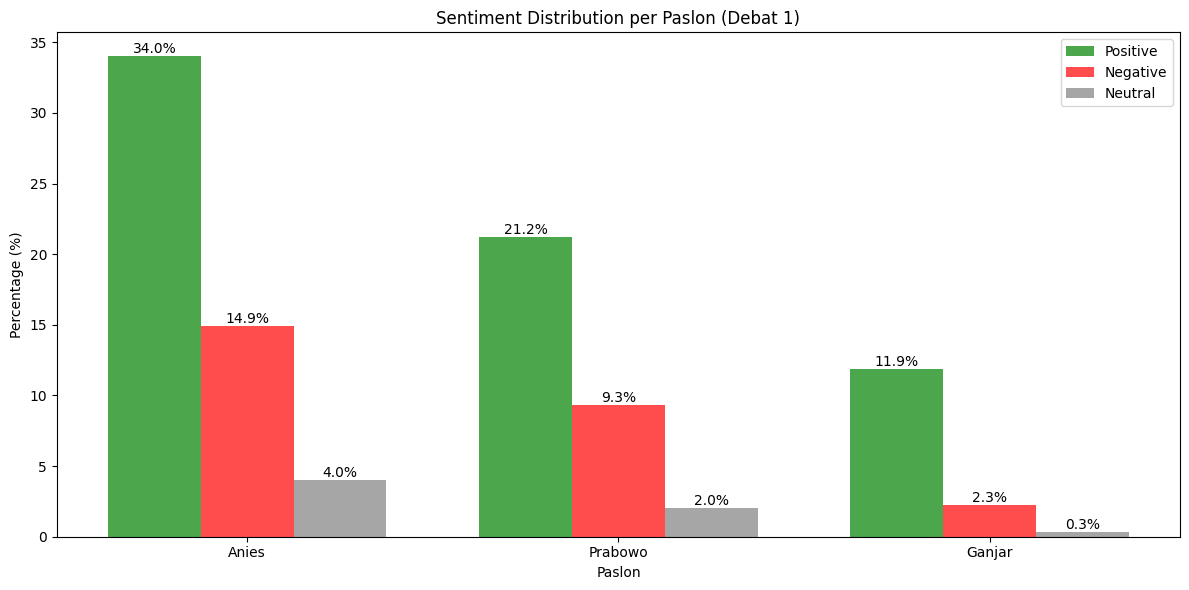

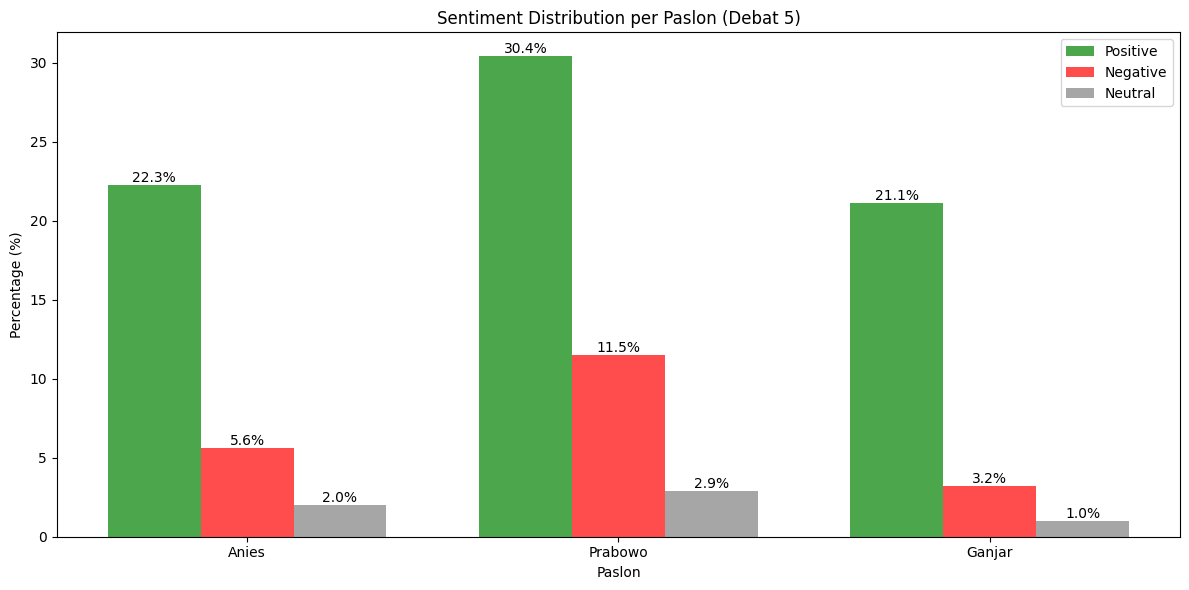


Sentiment Percentages per Paslon (Debat 1):
           Anies  Prabowo  Ganjar
Sentiment                        
Positive   34.00    21.19   11.89
Negative   14.90     9.35    2.28
Neutral     4.04     2.03    0.33

Sentiment Percentages per Paslon (Debat 5):
           Anies  Prabowo  Ganjar
Sentiment                        
Positive   22.28    30.42   21.11
Negative    5.64    11.49    3.22
Neutral     2.01     2.87    0.97

Spearman Correlation Analysis (Positive Sentiment - Debat 1):
Correlation: 0.500, P-value: 0.667
Spearman Correlation Analysis (Positive Sentiment - Debat 5):
Correlation: 1.000, P-value: 0.000

Spearman Correlation Analysis (Negative Sentiment - Debat 1):
Correlation: 0.500, P-value: 0.667
Spearman Correlation Analysis (Negative Sentiment - Debat 5):
Correlation: 1.000, P-value: 0.000

Spearman Correlation Analysis (Neutral Sentiment - Debat 1):
Correlation: 0.500, P-value: 0.667
Spearman Correlation Analysis (Neutral Sentiment - Debat 5):
Correlation: 1.000, P-

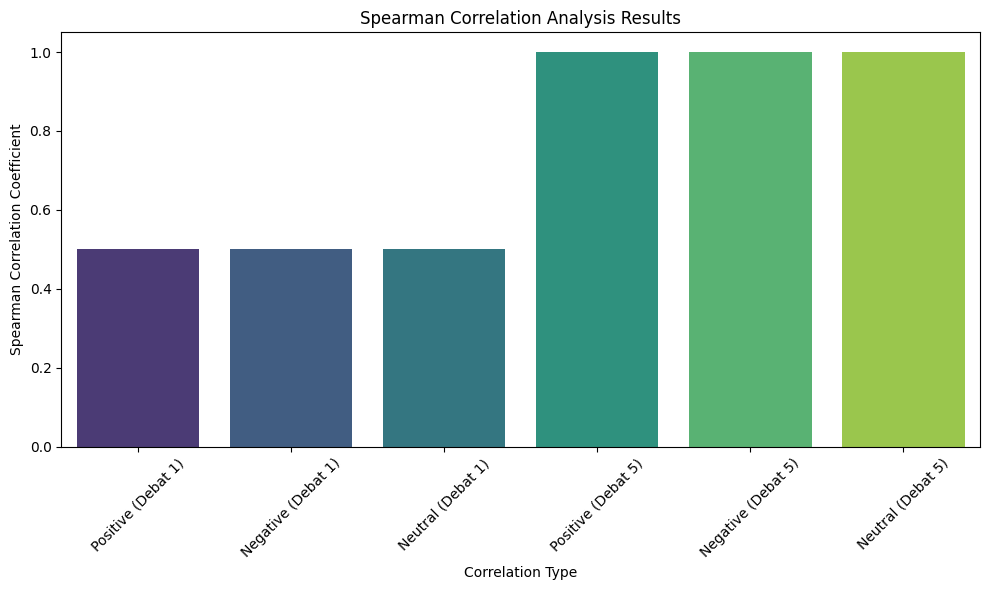

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

# Read the data
df = pd.read_csv('Proses/Hasil_Lexicon_TOTAL.csv')

# Convert Combined_Score to sentiment labels
df['Sentiment'] = df['Combined_Score'].apply(
    lambda x: 'Positive' if x > 0 else 'Negative' if x < 0 else 'Neutral'
)

# Function to calculate sentiment percentages for each Paslon based on total data
def calculate_sentiment_percentages(data, total_length):
    paslon_sentiment = pd.DataFrame()
    for paslon in data['Paslon'].unique():
        paslon_data = data[data['Paslon'] == paslon]
        sentiment_counts = paslon_data['Sentiment'].value_counts()
        percentages = (sentiment_counts / total_length) * 100
        paslon_sentiment[paslon] = percentages
    return paslon_sentiment

# Separate data based on Debat category
if 'Debat' in df.columns:
    debat1_data = df[df['Debat'] == 'Debat 1']
    debat5_data = df[df['Debat'] == 'Debat 5']

    total_length_debat1 = len(debat1_data)
    total_length_debat5 = len(debat5_data)

    # Calculate sentiment percentages for each Debat based on total data
    debat1_sentiment = calculate_sentiment_percentages(debat1_data, total_length_debat1)
    debat5_sentiment = calculate_sentiment_percentages(debat5_data, total_length_debat5)

    # Ensure all required sentiment labels are present in the DataFrame
    required_labels = ['Positive', 'Negative', 'Neutral']
    for label in required_labels:
        if label not in debat1_sentiment.index:
            debat1_sentiment.loc[label] = 0
        if label not in debat5_sentiment.index:
            debat5_sentiment.loc[label] = 0

    # Plotting for Debat 1
    plt.figure(figsize=(12, 6))
    bar_width = 0.25
    r1 = np.arange(len(debat1_sentiment.columns))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    plt.bar(r1, debat1_sentiment.loc['Positive'], width=bar_width, label='Positive', color='green', alpha=0.7)
    plt.bar(r2, debat1_sentiment.loc['Negative'], width=bar_width, label='Negative', color='red', alpha=0.7)
    plt.bar(r3, debat1_sentiment.loc['Neutral'], width=bar_width, label='Neutral', color='gray', alpha=0.7)

    for i, sentiment in enumerate(['Positive', 'Negative', 'Neutral']):
        for j in range(len(debat1_sentiment.columns)):
            value = debat1_sentiment.loc[sentiment, debat1_sentiment.columns[j]]
            x = j + i * bar_width
            plt.text(x, value, f'{value:.1f}%', ha='center', va='bottom')

    plt.xlabel('Paslon')
    plt.ylabel('Percentage (%)')
    plt.title('Sentiment Distribution per Paslon (Debat 1)')
    plt.xticks([r + bar_width for r in range(len(debat1_sentiment.columns))], debat1_sentiment.columns)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plotting for Debat 5
    plt.figure(figsize=(12, 6))
    r1 = np.arange(len(debat5_sentiment.columns))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    plt.bar(r1, debat5_sentiment.loc['Positive'], width=bar_width, label='Positive', color='green', alpha=0.7)
    plt.bar(r2, debat5_sentiment.loc['Negative'], width=bar_width, label='Negative', color='red', alpha=0.7)
    plt.bar(r3, debat5_sentiment.loc['Neutral'], width=bar_width, label='Neutral', color='gray', alpha=0.7)

    for i, sentiment in enumerate(['Positive', 'Negative', 'Neutral']):
        for j in range(len(debat5_sentiment.columns)):
            value = debat5_sentiment.loc[sentiment, debat5_sentiment.columns[j]]
            x = j + i * bar_width
            plt.text(x, value, f'{value:.1f}%', ha='center', va='bottom')

    plt.xlabel('Paslon')
    plt.ylabel('Percentage (%)')
    plt.title('Sentiment Distribution per Paslon (Debat 5)')
    plt.xticks([r + bar_width for r in range(len(debat5_sentiment.columns))], debat5_sentiment.columns)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Print numerical results
    print("\nSentiment Percentages per Paslon (Debat 1):")
    print(debat1_sentiment.round(2))

    print("\nSentiment Percentages per Paslon (Debat 5):")
    print(debat5_sentiment.round(2))

    # Real election results
    election_results = {
        'Anies': 24.9,
        'Prabowo': 58.6,
        'Ganjar': 16.5
    }

    # Function to calculate Spearman correlation safely
    def safe_spearmanr(x, y):
        if len(set(x)) > 1 and len(set(y)) > 1:
            return spearmanr(x, y)
        else:
            return (np.nan, np.nan)

    # Calculate Spearman correlation for each sentiment type and Debat
    for sentiment in required_labels:
        # Debat 1
        correlation_debat1, p_value_debat1 = safe_spearmanr(
            debat1_sentiment.loc[sentiment].values,
            list(election_results.values())
        )
        print(f"\nSpearman Correlation Analysis ({sentiment} Sentiment - Debat 1):")
        print(f"Correlation: {correlation_debat1:.3f}, P-value: {p_value_debat1:.3f}")

        # Debat 5
        correlation_debat5, p_value_debat5 = safe_spearmanr(
            debat5_sentiment.loc[sentiment].values,
            list(election_results.values())
        )
        print(f"Spearman Correlation Analysis ({sentiment} Sentiment - Debat 5):")
        print(f"Correlation: {correlation_debat5:.3f}, P-value: {p_value_debat5:.3f}")

    # Visualize the correlation results
    correlation_results = {
        'Positive (Debat 1)': safe_spearmanr(debat1_sentiment.loc['Positive'].values, list(election_results.values()))[0],
        'Negative (Debat 1)': safe_spearmanr(debat1_sentiment.loc['Negative'].values, list(election_results.values()))[0],
        'Neutral (Debat 1)': safe_spearmanr(debat1_sentiment.loc['Neutral'].values, list(election_results.values()))[0],
        'Positive (Debat 5)': safe_spearmanr(debat5_sentiment.loc['Positive'].values, list(election_results.values()))[0],
        'Negative (Debat 5)': safe_spearmanr(debat5_sentiment.loc['Negative'].values, list(election_results.values()))[0],
        'Neutral (Debat 5)': safe_spearmanr(debat5_sentiment.loc['Neutral'].values, list(election_results.values()))[0]
    }

    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(correlation_results.keys()), y=list(correlation_results.values()), palette='viridis')
    plt.xlabel('Correlation Type')
    plt.ylabel('Spearman Correlation Coefficient')
    plt.title('Spearman Correlation Analysis Results')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

else:
    print("Column 'Debat' not found in the DataFrame.")